# Paper results


In [88]:
from advection_diffusion_inference_utils import (read_data_files,
                                                 read_experiment_data,
                                                 all_animals,
                                                 all_ears,
                                                 plot_time_series,
                                                 create_time_steps,
                                                 build_grids,
                                                 create_domain_geometry,
                                                 create_PDE_form)


from cuqi.geometry import Continuous2D
from cuqi.pde import TimeDependentLinearPDE
from cuqi.model import PDEModel
import scipy.stats as sps
import cuqi
import matplotlib.pyplot as plt
import numpy as np

In [89]:
def create_A(data_diff):
    # STEP 2: Read time and location arrays
    #----------------------------------------
    args = data_diff['experiment_par']
    (real_times, real_locations, real_data, real_std_data,
     diff_locations, real_data_diff, real_std_data_diff) = read_data_files(args)
    

    # The left boundary condition is given by the data  
    real_bc_l = real_data.reshape([len(real_locations), len(real_times)])[0,:]

    real_bc_l[real_bc_l<0] = 0

    # The right boundary condition is given by the data (if rbc is not "zero")
    if args.rbc == 'fromData':
        raise Exception('Right boundary condition from data not supported')
    elif args.rbc == 'fromDataClip':
        real_bc_r = real_data.reshape([len(real_locations), len(real_times)])[-1,:]

        real_bc_r[real_bc_r<0] = 0

    
    else:
        real_bc_r = None
    
    if args.u0_from_data:
        real_u0 = real_data.reshape([len(real_locations), len(real_times)])[:,0]

        real_u0[real_u0<0] = 0

    
    # locations, including added locations that can be used in synthetic 
    # case only
    if len(args.add_data_pts) > 0:
        locations = np.concatenate((real_locations, np.array(args.add_data_pts)))
        # reorder the locations
        locations = np.sort(locations)
        diff_locations = locations[:-1]
    else:
        locations = real_locations
    # times
    times = real_times
    # STEP 4: Create the PDE grid and coefficients grid
    #----------------------------------------------------
    # PDE and coefficients grids
    factor_L = 1.2 if args.rbc == 'zero' else 1.01
    L = locations[-1]*factor_L
    coarsening_factor = 5
    n_grid_c = 20
    grid, grid_c, grid_c_fine, h, n_grid = build_grids(L, coarsening_factor, n_grid_c)
    
    # Step 4.1: Create u0
    #-----------------------
    if args.u0_from_data:
        # interpolate real_u0 to the grid
        u0 = np.interp(grid, locations, real_u0)
    else:
        u0 = None
    
    # STEP 5: Create the PDE time steps array
    #------------------------------------------
    tau_max = 30*60 # Final time in sec
    cfl = 5 # The cfl condition to have a stable solution
             # the method is implicit, we can choose relatively large time steps 
    tau = create_time_steps(h, cfl, tau_max, args.adaptive)
    
    # STEP 6: Create the domain geometry
    #-------------------------------------
    G_c = create_domain_geometry(grid_c, args.inference_type)
    
    # STEP 7: Create the PDE form
    #----------------------------
    PDE_form = create_PDE_form(real_bc_l, real_bc_r,
                               grid, grid_c, grid_c_fine, n_grid, h, times,
                               args.inference_type,
                               u0=u0)
    # STEP 8: Create the CUQIpy PDE object
    #-------------------------------------
    PDE = TimeDependentLinearPDE(PDE_form,
                                 tau,
                                 grid_sol=grid,
                                 method='backward_euler', 
                                 grid_obs=locations,
                                 time_obs=times,
                                 data_grad=args.data_grad) 
    
    # STEP 9: Create the range geometry
    #----------------------------------
    if args.data_grad:
        G_cont2D = Continuous2D((diff_locations, times))
    else:
        G_cont2D = Continuous2D((locations, times))
    
    # STEP 10: Create the CUQIpy PDE model
    #-------------------------------------
    A = PDEModel(PDE, range_geometry=G_cont2D, domain_geometry=G_c)

    return A
def read_all_scenarios(scenario_dir, scenario_tag, physics, animal_ear):
    
    # Read all cases for the scenario
    data_diff_list = []
    data_adv_list = []
    for animal, ear in animal_ear:
            # Read the experiment data
            data_diff_list.append(
                read_experiment_data(
                    scenario_dir+"/"+scenario_tag[0],
                    animal+"_"+ear+"_"+scenario_tag[2]
                    ))
            data_adv_list.append(
                read_experiment_data(
                    scenario_dir+"/"+scenario_tag[1],
                    animal+"_"+ear+"_"+scenario_tag[3]))
    return data_diff_list, data_adv_list

def plot_v3_fig1( data_diff_list, data_adv_list):
                
    # Create a figure with 10 rows and 3 columns. First column is for the
    # data, second column is for the prediction from the diffusion model,
    # and the third column is for the prediction from the advection model.
    fig, axs = plt.subplots(4, 3, figsize=(8, 8))
    #print(data_adv_list[0].keys())
    # dict_keys(['exact', 'exact_data', 'data', 'mean_recon_data', 'x_samples', 's_samples', 'experiment_par', 'locations', 'times', 'lapse_time', 'num_tree_node_list', 'epsilon_list'])
    for i in range(len(data_diff_list)):
        # Plot the data
        plt.sca(axs[i, 0])
        plot_time_series(data_diff_list[i]['times'], data_diff_list[i]['locations'],
                         data_diff_list[i]['data'], plot_legend=False)
        
        # Plot the prediction from the diffusion model
        plt.sca(axs[i, 1])
        plot_time_series(data_diff_list[i]['times'], data_diff_list[i]['locations'],
                         data_diff_list[i]['mean_recon_data'], plot_legend=False)
        #switch of ticks and label of y
        plt.ylabel('')
        
        # Plot the prediction from the advection model
        plt.sca(axs[i, 2])
        lines, legends = plot_time_series(data_adv_list[i]['times'], data_adv_list[i]['locations'],
                         data_adv_list[i]['mean_recon_data'])

        #switch of ticks and label of y
        plt.ylabel('') 

        # legend location after the last plot outside the plot

        plt.legend(lines, legends, loc='center left', bbox_to_anchor=(1, 0.5))

def plot_v3_fig1_b( data_diff_list, data_adv_list, fig_v="I", plot_type='over_time', colormap=None):
    # fig_v = "I" or "II" or "III"
                
    # Create a figure with 10 rows and 3 columns. First column is for the
    # data, second column is for the prediction from the diffusion model,
    # and the third column is for the prediction from the advection model.
    if fig_v == "I":
        fig, axs = plt.subplots(4, 3, figsize=(8, 8))
        # increase h space
        plt.subplots_adjust(wspace=0.3)
        # print(data_adv_list[0].keys())
        # dict_keys(['exact', 'exact_data', 'data', 'mean_recon_data', 'x_samples', 's_samples', 'experiment_par', 'locations', 'times', 'lapse_time', 'num_tree_node_list', 'epsilon_list'])
        for i in range(len(data_diff_list)):
            # Plot the data
            plt.sca(axs[i, 0])
            real_times, real_locations, real_data, real_std_data, diff_locations, real_data_diff, real_std_data_diff = read_data_files(data_diff_list[i]['experiment_par'])
            plot_time_series(real_times, real_locations,
                             real_data.reshape(len(real_locations), len(real_times)), plot_legend=False, plot_type=plot_type)
            print(data_diff_list[i]['experiment_par'])
            plt.ylabel('Concentration, '+data_diff_list[i]['experiment_par'].animal+' '+data_diff_list[i]['experiment_par'].ear)

            if i == 0:
                plt.title("Real data")

            
            # Plot the prediction from the diffusion model
            #---
            A = create_A(data_diff_list[i]) 
            mean_recon_data = \
                A(data_diff_list[i]["x_samples"].funvals.mean(), is_par=False)
            non_grad_mean_recon_data = A.pde._solution_obs


            plt.sca(axs[i, 1])
            plot_time_series(real_times, real_locations,
                             non_grad_mean_recon_data, plot_legend=False, plot_type=plot_type)
            #switch of ticks and label of y
            plt.ylabel('')
            if i == 0:
                plt.title("Diffusion model\n prediction") 
            #---
            # Plot the prediction from the advection model
            #---
            try:
                A = create_A(data_adv_list[i])
                mean_recon_data = \
                    A(data_adv_list[i]["x_samples"].funvals.mean(), is_par=False)
                non_grad_mean_recon_data = A.pde._solution_obs

                plt.sca(axs[i, 2])
                lines, legends = plot_time_series(real_times, real_locations,
                                 non_grad_mean_recon_data, plot_legend=False, plot_type=plot_type)
                #switch of ticks and label of y
                plt.ylabel('')
                # legend location after the last plot outside the plot
                plt.legend(lines, legends, loc='center left', bbox_to_anchor=(1, 0.5)) 
                if i == 0:
                    plt.title("Diffusion-advection\n model prediction")
                plt.text(20, 3000, "mean a\n{:.2f}".format(data_adv_list[i]['x_samples'].funvals.mean()[-1]), fontsize=10)
            except:
                pass



           
            
    elif fig_v == "II":
        # same as version one but two columns, plot the real data overlaid with the prediction
        fig, axs = plt.subplots(4, 3, figsize=(10, 8))
        # increase h space
        plt.subplots_adjust(wspace=0.3)
        # print(data_adv_list[0].keys())
        # dict_keys(['exact', 'exact_data', 'data', 'mean_recon_data', 'x_samples', 's_samples', 'experiment_par', 'locations', 'times', 'lapse_time', 'num_tree_node_list', 'epsilon_list'])
        for i in range(len(data_diff_list)):

            # Plot the data


            #if i == 0:
            #    plt.title("Real data")

            real_times, real_locations, real_data, real_std_data, diff_locations, real_data_diff, real_std_data_diff = read_data_files(data_diff_list[i]['experiment_par'])
            # Plot the prediction from the diffusion model
            #---
            A = create_A(data_diff_list[i]) 
            mean_recon_data = \
                A(data_diff_list[i]["x_samples"].funvals.mean(), is_par=False)
            non_grad_mean_recon_data_diffu = A.pde._solution_obs


            plt.sca(axs[i, 0])
            plot_time_series(real_times, real_locations,
                             non_grad_mean_recon_data_diffu, plot_legend=False, plot_type=plot_type, colormap=colormap)
            #switch of ticks and label of y
            plt.ylabel('')
            

            plot_time_series(real_times, real_locations,
                             real_data.reshape(len(real_locations), len(real_times)), plot_legend=False, marker = '*', linestyle = 'None', plot_type=plot_type, colormap=colormap)
            #print(data_diff_list[i]['experiment_par'])
            plt.ylabel('Concentration, '+data_diff_list[i]['experiment_par'].animal+' '+data_diff_list[i]['experiment_par'].ear)
            plt.ylim(0, 5700)
            if i == 0:
                plt.title("Diffusion model\n prediction") 
            #---
            # Plot the prediction from the advection model
            #---
            try:
                A = create_A(data_adv_list[i])
                mean_recon_data = \
                    A(data_adv_list[i]["x_samples"].funvals.mean(), is_par=False)
                non_grad_mean_recon_data_adv = A.pde._solution_obs

                plt.sca(axs[i, 1])
                lines, legends = plot_time_series(real_times, real_locations,
                                 non_grad_mean_recon_data_adv, plot_legend=False, plot_type=plot_type, colormap=colormap)
                #switch of ticks and label of y
                plot_time_series(real_times, real_locations,
                real_data.reshape(len(real_locations), len(real_times)), plot_legend=False, marker = '*', linestyle = 'None', plot_type=plot_type, colormap=colormap)
                plt.ylabel('')
                plt.ylim(0, 5750)
                # no legend
                plt.legend().set_visible(False)
                if i == 0:
                    plt.title("Diffusion-advection\n model prediction")
                plt.text(20, 4000, "mean a\n{:.2f}".format(data_adv_list[i]['x_samples'].funvals.mean()[-1]), fontsize=10)
            except:
                pass

            # Plot the difference between the advection and the diffusion model
            #---
            plt.sca(axs[i, 2])
            plot_time_series(real_times, real_locations,
                             non_grad_mean_recon_data_diffu, plot_legend=False, plot_type=plot_type, colormap=colormap)
            plot_time_series(real_times, real_locations,
                             non_grad_mean_recon_data_adv, plot_legend=False, plot_type=plot_type, colormap=colormap, linestyle='--')
            plt.ylabel('')
            plt.ylim(0, 5750)
            # legend location after the last plot outside the plot
            plt.legend(lines, legends, loc='center left', bbox_to_anchor=(1, 0.5)) 
            if i == 0:
                plt.title("Diff. Diffusion-advection\n & diffusion prediction")
    elif fig_v == "III":
        #same as one but with additional 2 columns for the difference between the real data and the prediction
        fig, axs = plt.subplots(4, 5, figsize=(12, 8))
        # increase h space
        #plt.subplots_adjust(wspace=0.3)
        # print(data_adv_list[0].keys())
        # dict_keys(['exact', 'exact_data', 'data', 'mean_recon_data', 'x_samples', 's_samples', 'experiment_par', 'locations', 'times', 'lapse_time', 'num_tree_node_list', 'epsilon_list'])
        for i in range(len(data_diff_list)):
            # Plot the data
            plt.sca(axs[i, 0])
            real_times, real_locations, real_data, real_std_data, diff_locations, real_data_diff, real_std_data_diff = read_data_files(data_diff_list[i]['experiment_par'])
            plot_time_series(real_times, real_locations,
                             real_data.reshape(len(real_locations), len(real_times)), plot_legend=False, plot_type=plot_type)
            plt.ylim(-1000, 5700)
            print(data_diff_list[i]['experiment_par'])
            plt.ylabel('Concentration, '+data_diff_list[i]['experiment_par'].animal+' '+data_diff_list[i]['experiment_par'].ear)

            if i == 0:
                plt.title("Real data")

            
            # Plot the prediction from the diffusion model
            #---
            A = create_A(data_diff_list[i]) 
            mean_recon_data = \
                A(data_diff_list[i]["x_samples"].funvals.mean(), is_par=False)
            non_grad_mean_recon_data = A.pde._solution_obs


            plt.sca(axs[i, 1])
            plot_time_series(real_times, real_locations,
                             non_grad_mean_recon_data, plot_legend=False, plot_type=plot_type)
            plt.ylim(-1000, 5700)
            #switch of ticks and label of y
            plt.ylabel('')
            if i == 0:
                plt.title("Diffusion model\n prediction") 

            plt.sca(axs[i, 2])
            plot_time_series(real_times, real_locations,
                             real_data.reshape(len(real_locations), len(real_times))-non_grad_mean_recon_data, plot_legend=False, plot_type=plot_type)
            plt.ylim(-1000, 5700)
            plt.ylabel('')
            #---
            # Plot the prediction from the advection model
            #---
            try:
                A = create_A(data_adv_list[i])
                mean_recon_data = \
                    A(data_adv_list[i]["x_samples"].funvals.mean(), is_par=False)
                non_grad_mean_recon_data = A.pde._solution_obs

                plt.sca(axs[i, 3])
                lines, legends = plot_time_series(real_times, real_locations,
                                 non_grad_mean_recon_data, plot_legend=False, plot_type=plot_type)
                plt.ylim(-1000, 5700)
                #switch of ticks and label of y
                plt.ylabel('')
 
                if i == 0:
                    plt.title("Diffusion-advection\n model prediction")
                plt.text(20, 3000, "mean a\n{:.2f}".format(data_adv_list[i]['x_samples'].funvals.mean()[-1]), fontsize=10)
                # plot difference between real data and prediction
                                # legend location after the last plot outside the plot
                plt.sca(axs[i, 4])
                plot_time_series(real_times, real_locations,
                                real_data.reshape(len(real_locations), len(real_times))-non_grad_mean_recon_data, plot_legend=False, plot_type=plot_type)
                plt.ylim(-1000, 5700)
                plt.ylabel('')
                plt.legend(lines, legends, loc='center left', bbox_to_anchor=(1, 0.5))
            except:
                pass

        


    
# dir_name +'/output'+ tag+'/'+tag+'_var.pkl'
def plot_v3_fig2(data_diff_list, data_adv_list):
    # create a 10 by 3 plot, each row is for a different animal and ear
    # the first column is for the credibility interval of the inferred
    # diffusion parameter, the second column is for the prior and posterior
    # of the advection parameter, and the third column is for the prior and
    # posterior of the GIBBS parameter
    fig, axs = plt.subplots(4, 3, figsize=(8, 8))
    # add wspace
    plt.subplots_adjust(wspace=0.3)


    for i in range(len(data_diff_list)):
        # Plot the credibility interval of the inferred diffusion parameter
        plt.sca(axs[i, 0])
        l_ci1 = data_diff_list[i]['x_samples'].funvals.plot_ci(68)
        
        try:
            l_ci2 = cuqi.samples.Samples(data_adv_list[i]['x_samples'].samples[:-1,:], geometry=data_diff_list[i]['x_samples'].geometry).funvals.plot_ci( 68, plot_envelope_kwargs={'facecolor': 'g'}, color='g')
        except:
            pass
        # plot legend before first column
        if i == 3:
            plt.legend([l_ci1[0], l_ci1[2], l_ci2[0], l_ci2[2]], ['mean (Diff.)',  '68% CI (Diff.)', 'mean (Adv.-Diff.)', '68% CI (Adv.-Diff.)'], loc='center left', bbox_to_anchor=(-.2, -0.5), ncol=4)
        else:
            # set legend to off
            plt.legend().set_visible(False)
        # compute ESS min
        ESS_diff = np.min(data_diff_list[i]['x_samples'].compute_ess())
        try:
            ESS_adv = np.min(data_adv_list[i]['x_samples'].compute_ess())
        except:
            ESS_adv=0
            pass
        # add it to the plot
        #plt.
        # (10, 1000, 'ESS: \n'+str(int(ESS_diff))+'\n'+str(int(ESS_adv)), fontsize=12)
        if i == 0:
            plt.title("Diff. parameter inference")
        if ESS_adv != 0:
            # plot the prior and posterior of the advection parameter
            plt.sca(axs[i, 1])
            var_a_sqrt = 0.752**2
            var_a = 2*var_a_sqrt**2
            prior2 =cuqi.distribution.Gaussian(0, var_a) #TODO: store
            v_min = -3
            v_max = 3
            cuqi.utilities.plot_1D_density(prior2, v_min=v_min, v_max=v_max, color='b',label='prior')
            #plt.hist(data_adv_list[i]['x_samples'].samples[-1,:].flatten(), bins=50, alpha=0.5, label='$a$', color='orange')

            
            kde = sps.gaussian_kde(data_adv_list[i]['x_samples'].samples[-1,:].flatten())
            x = np.linspace(v_min, v_max, 100)
            l1 = plt.plot(x, kde(x), color='black', label='posterior')
            if i == 0:
                plt.legend()
            if i==0:
                plt.title("Adv. parameter inference") 
                

            # plot the gibbs
            plt.sca(axs[i, 2])
            s = cuqi.distribution.Gamma(1.2, 5) #TODO: store
            s_samples = s.sample(10000)
            v_min = 0
            v_max = 10
            if i == 0:  
                plt.title("Noise level inference")
                
            #cuqi.utilities.plot_1D_density(s, v_min=v_min, v_max=v_max, color='b',label='prior')
            kde_1 = sps.gaussian_kde(1/np.sqrt(s_samples.samples.flatten())) 
            kde_2 = sps.gaussian_kde(1/np.sqrt(data_adv_list[i]['s_samples'].samples.flatten()))
            x = np.linspace(v_min, v_max, 100)
            l1 = plt.plot(x, kde_1(x), color='blue', label='prior')
            l2 = plt.plot(x, kde_2(x), color='black', label='posterior')
            if i == 0:
                plt.legend()
            #plt.legend()
        

def plot_v3_intro_data(data_diff_list, data_adv_list, plot_type='over_time'):
    # plot real data time series for first animal and ear (one row/ one column)
    
    if plot_type == 'over_time' or plot_type == 'over_location':
        fig = plt.figure(figsize=(4, 2))
    else:
        fig = plt.figure(figsize=(4, 4))
    # set left, right, top, bottom to 0.1, 0.9, 0.9, 0.1
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)
    #plt.sca(plt.subplot(111))

    real_times, real_locations, real_data, real_std_data, diff_locations, real_data_diff, real_std_data_diff = read_data_files(data_diff_list[0]['experiment_par'])
    lines, legend = plot_time_series(real_times, real_locations,
                     real_data.reshape(len(real_locations), len(real_times)), plot_legend=False, plot_type=plot_type, d3_alpha=0.85)
    return lines, legend
    # fix label does not show properly
    #plt.ylabel('Concentration')






In [90]:
def plot_v3_fig2_II(data_diff_list, data_adv_list, data_diff_list_all, data_adv_list_all):
    # create a 10 by 3 plot, each row is for a different animal and ear
    # the first column is for the credibility interval of the inferred
    # diffusion parameter, the second column is for the prior and posterior
    # of the advection parameter, and the third column is for the prior and
    # posterior of the GIBBS parameter
    fig, axs = plt.subplots(5, 4, figsize=(10, 12))
    # add wspace
    plt.subplots_adjust(wspace=0.3)


    for i in range(len(data_diff_list)):
        # Plot the credibility interval of the inferred diffusion parameter
        plt.sca(axs[i, 0])
        l_ci1 = data_diff_list[i]['x_samples'].funvals.plot_ci(68)
        
        try:
            l_ci2 = cuqi.samples.Samples(data_adv_list[i]['x_samples'].samples[:-1,:], geometry=data_diff_list[i]['x_samples'].geometry).funvals.plot_ci( 68, plot_envelope_kwargs={'facecolor': 'g'}, color='g')
        except:
            pass
        # plot legend before first column
        if i == 3:
            plt.legend([l_ci1[0], l_ci1[2], l_ci2[0], l_ci2[2]], ['mean (Diff.)',  '68% CI (Diff.)', 'mean (Adv.-Diff.)', '68% CI (Adv.-Diff.)'], loc='center left', bbox_to_anchor=(-.2, -1.7), ncol=4)
        else:
            # set legend to off
            plt.legend().set_visible(False)
        # compute ESS min
        ESS_diff = np.min(data_diff_list[i]['x_samples'].compute_ess())
        try:
            ESS_adv = np.min(data_adv_list[i]['x_samples'].compute_ess())
        except:
            ESS_adv=0
            pass
        plt.ylim(100, 750)
        # add it to the plot
        #plt.
        # (10, 1000, 'ESS: \n'+str(int(ESS_diff))+'\n'+str(int(ESS_adv)), fontsize=12)
        if i == 0:
            plt.title("Diff. parameter inference")
        if ESS_adv != 0:
            # plot the prior and posterior of the advection parameter
            plt.sca(axs[i, 1])
            var_a_sqrt = 0.752**2
            var_a = 2*var_a_sqrt**2
            prior2 =cuqi.distribution.Gaussian(0, var_a) #TODO: store
            v_min = -3
            v_max = 3
            cuqi.utilities.plot_1D_density(prior2, v_min=v_min, v_max=v_max, color='b',label='prior')
            #plt.hist(data_adv_list[i]['x_samples'].samples[-1,:].flatten(), bins=50, alpha=0.5, label='$a$', color='orange')

            
            kde = sps.gaussian_kde(data_adv_list[i]['x_samples'].samples[-1,:].flatten())
            x = np.linspace(v_min, v_max, 100)
            l1 = plt.plot(x, kde(x), color='black', label='posterior')
            if i == 0:
                plt.legend()
            if i==0:
                plt.title("Adv. parameter inference") 
                

            # plot the gibbs
            plt.sca(axs[i, 2])
            s = cuqi.distribution.Gamma(1.2, 5) #TODO: store
            s_samples = s.sample(10000)
            v_min2 = 0
            v_max2 = 10
            if i == 0:  
                plt.title("Noise level inference")
                
            #cuqi.utilities.plot_1D_density(s, v_min=v_min, v_max=v_max, color='b',label='prior')
            kde_1 = sps.gaussian_kde(1/np.sqrt(s_samples.samples.flatten())) 
            kde_2 = sps.gaussian_kde(1/np.sqrt(data_adv_list[i]['s_samples'].samples.flatten()))
            x2 = np.linspace(v_min2, v_max2, 100)
            l1 = plt.plot(x2, kde_1(x2), color='blue', label='prior')
            l2 = plt.plot(x2, kde_2(x2), color='black', label='posterior')
            if i == 0:
                plt.legend()
            #plt.legend()

            
            # plot scatter plot of mean diffusion and advection
            plt.sca(axs[i, 3])
                # samples of average diffusion
            samples_diff_avg = np.array([np.average(data_adv_list[i]['x_samples'].samples[:-1,j]) for j in range(data_adv_list[i]['x_samples'].Ns)])
            # stack advection and diffusion
            diff_adv = cuqi.samples.Samples(np.vstack(
                                    (samples_diff_avg, data_adv_list[i]['x_samples'].samples[-1,:])))
            diff_adv.geometry = cuqi.geometry.MappedGeometry( cuqi.geometry.Discrete(['$c^2_\mathrm{avg}$', '$a$']), data_adv_list[0]['x_samples'].geometry.map)

            # plot the correlation
            color_list = ['b']*4
            diff_adv.funvals.plot_pair(ax=plt.gca(), scatter_kwargs={'alpha':0.5, 'color':color_list[i]})
            plt.xlim(v_min, v_max)
            plt.ylim(100, 750)

    color_map_string = 'coolwarm' #'twilight' #'terrain'#'coolwarm'#'berlin' #'brg'
    skip_middle = False
    colormap=plt.colormaps.get_cmap(color_map_string)
    # create color list for the len(data_diff_list_all) lines but skip the white in the middle
    if skip_middle:
        color_list = [colormap(i) for i in np.linspace(0, 1, len(data_diff_list_all)+4)]
        color_list = color_list[:4]+color_list[5:] 
    else:
        color_list = [colormap(i) for i in np.linspace(0, 1, len(data_diff_list_all))]
    for i in range(len(data_diff_list_all)):
        
        if True:
            plt.sca(axs[4, 0])
            # plot all the means
            l_ci4 = cuqi.samples.Samples(data_adv_list_all[i]['x_samples'].samples[:-1,:], geometry=data_diff_list_all[i]['x_samples'].geometry).plot_mean(color=color_list[i])
            plt.title("")
            plt.ylim(100, 750)

            plt.sca(axs[4, 1])
            # plot all the posteriors and a prior of the advection parameter
            if i == 0:
                cuqi.utilities.plot_1D_density(prior2, v_min=v_min, v_max=v_max, color='b',label='prior')
                        
            kde = sps.gaussian_kde(data_adv_list_all[i]['x_samples'].samples[-1,:].flatten())
            x = np.linspace(v_min, v_max, 100)

            l1 = plt.plot(x, kde(x), color=color_list[i],
                          label='posterior')
            plt.xlim(v_min, v_max)
        
            plt.sca(axs[4, 2])
            # plot all the posteriors and a prior of the gibbs parameter
            if i == 0:
                l1 = plt.plot(x2, kde_1(x2), color='blue', label='prior')
            kde_2 = sps.gaussian_kde(1/np.sqrt(data_adv_list_all[i]['s_samples'].samples.flatten()))
            x2 = np.linspace(v_min2, v_max2, 100)
            l1 = plt.plot(x2, kde_2(x2), color=color_list[i], label='posterior')
    # remove axs[4, 3]
    fig.delaxes(axs[4, 3])

        

Reading file:  /Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_nov30/paperV4CARealDiff_Gauss4_gibbs_scale_all/outputm3_l_NUTSWithGibbs_constant_100.0_real_heterogeneous_2000_0.2_paperV4CARealDiff_Gauss4_gibbs_scale_all__0_5_0.1_fromDataClip/m3_l_NUTSWithGibbs_constant_100.0_real_heterogeneous_2000_0.2_paperV4CARealDiff_Gauss4_gibbs_scale_all__0_5_0.1_fromDataClip_var.pkl
Reading file:  /Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_nov30/paperV4CARealAdvDiff_Gauss4_gibbs_scale_all/outputm3_l_NUTSWithGibbs_constant_100.0_real_advection_diffusion_2000_0.2_paperV4CARealAdvDiff_Gauss4_gibbs_scale_all__0_5_0.1_fromDataClip/m3_l_NUTSWithGibbs_constant_100.0_real_advection_diffusion_2000_0.2_paperV4CARealAdvDiff_Gauss4_gibbs_scale_all__0_5_0.1_fromDataClip_var.pkl
Reading file:  /Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_

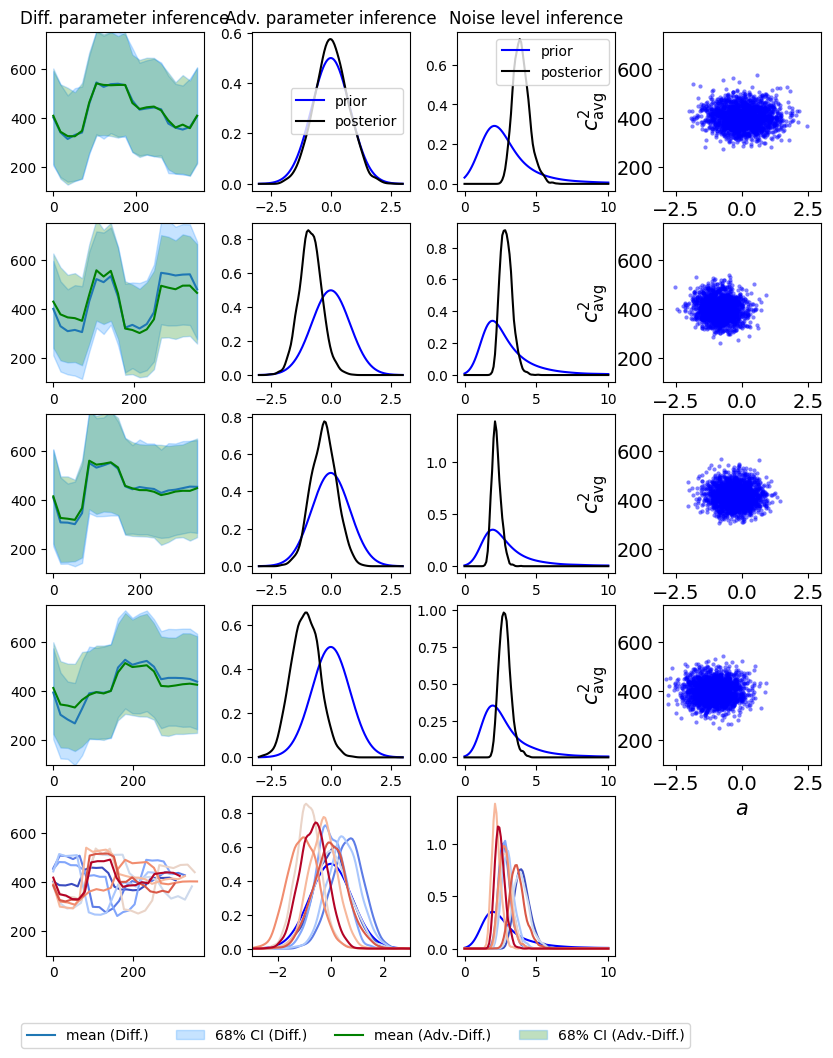

In [91]:
scenarios_dir = [
    "/Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_dec1",
    "/Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_nov30",
    "/Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_nov30"
    ]
scenario_tags_list = [
    ["paperV4CARealDiff_Gauess_gibbs_scale_all7",
     "paperV4CARealAdvDiff_Gauess_gibbs_scale_all7",
     "NUTSWithGibbs_constant_100.0_real_heterogeneous_2000_0.2_paperV4CARealDiff_Gauess_gibbs_scale_all7__0_5_0.1_fromDataClip",
     "NUTSWithGibbs_constant_100.0_real_advection_diffusion_2000_0.2_paperV4CARealAdvDiff_Gauess_gibbs_scale_all7__0_5_0.1_fromDataClip"],
    ["paperV4CARealDiff_Gauss4_gibbs_scale_all",
     "paperV4CARealAdvDiff_Gauss4_gibbs_scale_all",
     "NUTSWithGibbs_constant_100.0_real_heterogeneous_2000_0.2_paperV4CARealDiff_Gauss4_gibbs_scale_all__0_5_0.1_fromDataClip",
     "NUTSWithGibbs_constant_100.0_real_advection_diffusion_2000_0.2_paperV4CARealAdvDiff_Gauss4_gibbs_scale_all__0_5_0.1_fromDataClip"],
    ["paperV4CARealDiff_Gauss4_b_small_noise",
     None,
     "NUTS_constant_100.0_real_heterogeneous_2000_0.1_paperV4CARealDiff_Gauss4_b_small_noise__0_5_0.1_fromDataClip",
     None]


    ]

num_scenarios = len(scenarios_dir)
figs_to_plot = [[2]]*num_scenarios
physics = [['diffusion', 'advection-diffusion']]*num_scenarios

i = 1
animal_ear = [
    ('m3', 'l'),
    ('m3', 'r'),
    ('m4', 'l'),
    ('m4', 'r')
    ]
all_animals_ears = []
for animal in all_animals():
    for ear in all_ears():
        all_animals_ears.append((animal, ear))
data_diff_list, data_adv_list = read_all_scenarios(scenarios_dir[i], scenario_tags_list[i], physics[i], animal_ear)
data_diff_list_all, data_adv_list_all = read_all_scenarios(scenarios_dir[i], scenario_tags_list[i], physics[i], all_animals_ears)
if 1 in figs_to_plot[i]:
        #plot_v3_fig1( data_diff_list, data_adv_list)
        # create directory if it does not exist
        import os
        #os.makedirs('figures/'+scenario_tags_list[i][0], exist_ok=True)
        #plt.tight_layout()
        #plt.savefig('figures/'+scenario_tags_list[i][0]+'/fig1.png')
        plot_v3_fig1_b( data_diff_list, data_adv_list, fig_v='I')
        plt.tight_layout()
        #plt.savefig('figures/'+scenario_tags_list[i][0]+'/fig1_b_I.png')
        #plot_v3_fig1_b( data_diff_list, data_adv_list, fig_v='II')
        #plt.tight_layout()
        #plt.savefig('figures/'+scenario_tags_list[i][0]+'/fig1_b_II.png')
        #color_map_string = 'cool'
        #plot_v3_fig1_b( data_diff_list, data_adv_list, fig_v='II', plot_type='over_location', colormap=plt.colormaps.get_cmap(color_map_string))
        #plt.tight_layout()
        #plt.savefig('figures/'+scenario_tags_list[i][0]+'/fig1_b_II_location'+color_map_string+'.png')
        #plot_v3_fig1_b( data_diff_list, data_adv_list, fig_v='III', plot_type='over_time')
        #plt.tight_layout()
        #plt.savefig('figures/'+scenario_tags_list[i][0]+'/fig1_b_III.png')
        pass
if 2 in figs_to_plot[i]:
        plot_v3_fig2_II( data_diff_list, data_adv_list, data_diff_list_all, data_adv_list_all)
        plt.savefig('figures/'+scenario_tags_list[i][0]+'/fig2.png')

if 3 in figs_to_plot[i]:
        lines, legend = plot_v3_intro_data( data_diff_list, data_adv_list, plot_type='surface')
        ax = plt.gca()
        ax.view_init(45, 45)
        # update vertical axis to reduce number of ticks
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax.zaxis.set_major_locator(plt.MaxNLocator(5))
        ax.set_box_aspect(aspect=None, zoom=0.75)
        plt.tight_layout()
        plt.savefig('figures/'+scenario_tags_list[i][0]+'/fig3_surface.png')


        # plot over time
        lines, legend = plot_v3_intro_data( data_diff_list, data_adv_list, plot_type='over_time')
        # add legend outside the plot
        plt.legend(lines, legend, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.savefig('figures/'+scenario_tags_list[i][0]+'/fig3_over_time.png')

        # plot over space
        lines, legend = plot_v3_intro_data( data_diff_list, data_adv_list, plot_type='over_location')
        # add legend outside the plot
        plt.legend(lines, legend, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.savefig('figures/'+scenario_tags_list[i][0]+'/fig3_over_space.png')

        # control transparency
        

'/Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_dec1/paperV4CARealAdvDiff_Gauess_gibbs_scale_all7/outputm1_l_NUTSWithGibbs_constant_100.0_real_heterogeneous_2000_0.2_paperV4CARealAdvDiff_Gauess_gibbs_scale_all7__0_5_0.1_fromDataClip/m1_l_NUTSWithGibbs_constant_100.0_real_heterogeneous_2000_0.2_paperV4CARealAdvDiff_Gauess_gibbs_scale_all7__0_5_0.1_fromDataClip_var.pkl'